In [ ]:
# Key imports
! pip install boto3
! pip install botocore

import torch
import torch.nn as nn
import torchaudio.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, random_split, DataLoader
import torchaudio
from torchvision.utils import make_grid

import random
from scipy.signal import butter,filtfilt
from scipy import signal

import tqdm
from torch.optim import Adam

import functools

import io
import os
import tarfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio, display

import pandas as pd
import numpy as np

from math import sqrt

import matplotlib.pyplot as plt

import librosa as lb
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io
from scipy.io.wavfile import read, write

from IPython.display import Audio
from numpy.fft import fft, ifft

import os
import os.path
from os import path

import torch
import torch.utils.data as data

import os
import csv
from itertools import chain
import numpy as np
from natsort import natsorted
import math
import torchvision.transforms as transform
import soundfile as sf 

import librosa, librosa.display

%matplotlib inline

     |████████████████████████████████| 132 kB 5.3 MB/s 
     |████████████████████████████████| 8.7 MB 29.1 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 138 kB 45.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

# **Useful functions**

## Data processing

We define a range of function to process our initial data (36 wavfiles containing the same note played by 59 different instruments) to create a standardized dataset.

In [ ]:
#### FUNCTION -> to_slices
#### Create an array of equal size slices from the initial WAV file ####
  ## INPUTS:
    # path_to_file: the path to the WAV file
    # slice_duration: the sampling we want (duration of each slice) in s
  ## OUTPUT:
    # A list of all the slices
def to_slices(path_to_file,slice_duration):

    # Get the WAV file as a numpy array and the samplerate (number of points per second)
    samplerate, data = wavfile.read(path_to_file)

    # Print total length and number of channels (mono, stereo, etc)
    length = data.shape[0] / samplerate
    # print(f"length = {length}s")
    # print(f"number of channels = {data.shape[1]}")

    # Define an array to contain the slices
    slice_array = []

    # With the following iteration we risk loosing the last few seconds of the file
      # It is still better than loosing the beginning because we want to respect the measures and tempo
      # We are mainly interested in the "middle" of each song


    for i in range(int(length/slice_duration)): 
      slice = data[round(slice_duration*i*samplerate):round(slice_duration*(i+1)*samplerate)]

      name = (path_to_file.split('.')[0] + '_' + str(i)+ '.' + path_to_file.split('.')[1]).split('/')[-1]
      slice_array.append([name, samplerate, slice.astype(np.int16)])
    
    return slice_array


#### FUNCTION -> write_slices
#### Write the slices as WAV files in a given folder ####
  ## INPUTS:
    # path_to_file: the path to the folder
    # slice_array: a list of all the slices (WAV files)
def write_slice(slice_array, path_to_folder = '', infos = False):

  # Create the folder if it does not exist already
  if not(path.exists(path_to_folder)):
    os.makedirs(path_to_folder)

  for slice in slice_array:
    path_to_file, samplerate, file = slice[0], slice[1], slice[2]
    write(path_to_folder + '/' + path_to_file, samplerate, file)
  
  if infos:
    return str(len(slice_array)) + ' files have been sliced and saved in the folder ' + path_to_folder

  return 


#### FUNCTION -> transform_directory
#### Write the slices as WAV files in a given folder for all the wav files in a directory ####
  ## INPUTS:
    # input_directory: the path to the folder containing the initial files
    # output_directory: the destination folder
def transform_directory(input_directory, output_directory, slice_duration):
  slice_array = []
  
  # Iterate recursively on all the wav files in the directory
  for subdir, dirs, files in os.walk(input_directory):
    for file in files:
      path_to_file = os.path.join(subdir, file)
      if path_to_file.endswith('.wav'):
        slice_array.append(to_slices(path_to_file, slice_duration))
  
  # Create the files in the output directory
  for file_slice in slice_array:
    write_slice(file_slice,output_directory)

  return str(len(slice_array)) + ' files have been created in the folder ' + output_directory

#### FUNCTION -> cut_file
#### Change the start time and end time of a file ####
  ## INPUTS:
    # path_to_file
    # start_time
    # end_time
  ## OUTPUT:
    # edited file
def cut_file(path_to_file, start_time = 0, end_time = -1):
    # Get the WAV file as a numpy array and the samplerate (number of points per second)
    samplerate, data = wavfile.read(path_to_file)

    # Cut the file
    data = data[start_time*samplerate:end_time*samplerate]

    # Overwrite the file
    write(path_to_file, samplerate, data)

    return path_to_file + ' ok' 


#### FUNCTION -> get_square_time
### A function to obtain slices that can be converted to square matrixes
def get_square_time(duration, sample_rate):
  return (int(sqrt(duration*sample_rate))**2)/sample_rate

## Exploration with torchaudio

In [ ]:
#### FUNCTION -> print_stats
### Print the key statistics for a given waveform
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

#### FUNCTION -> plot_waveform
### Use matplotlib to plot the a weveform
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

#### FUNCTION -> plot_spectrogram
### Plot the waveform's spectrogram
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")

## Dataset class

In [ ]:
#### FUNCTION -> file_list
#### Return the list of all the files with a specific extension in a directory ####
  ## INPUTS:
    # directory
    # extension
  ## OUTPUT:
    # A list of all the files
def file_list(directory,extension):
	filelist = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.' + extension)]
	return filelist


#### CLASS -> AudioDataset
### Takes the output_directory path as an input and generate a dataset. Labels are not useful here; we use the id of the original file as a label.
class AudioDataset(Dataset):
  def __init__(self, audio_directory, param_directory = None, normalize = False, extension = 'wav'):
    super().__init__()
    self.audio_directory = audio_directory

    self.file_list = file_list(audio_directory, extension)

    self.normalize = normalize

    if param_directory is not None:
      self.param_directory = param_directory
    else:
      param_list = []
      for file in self.file_list:
        param_list.append(file.split('_')[1])
      self.param_directory = param_list

  # Reshape the waveform into 128 x 128 tensor in the getitem method to load in the dataloader
  def __getitem__(self, idx):
    path_to_file = self.file_list[idx]
    waveform, _ = torchaudio.load(path_to_file)
    label = self.param_directory[idx]

    if self.normalize == 'squared_matrix':
      n = round(sqrt(waveform[0].shape[0]))
      n_channels = waveform.shape[0]
      waveform = waveform.reshape(n_channels,n,n)
    
    return waveform, label

  def __len__(self):
    return len(self.file_list)

  def get_file_name(self,idx):
    return self.file_list[idx]

## Likelihood computation

In [ ]:
def prior_likelihood(z, sigma):
  """The likelihood of a Gaussian distribution with mean zero and 
      standard deviation sigma."""
  shape = z.shape
  N = np.prod(shape[1:])
  return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=(1,2,3)) / (2 * sigma**2)

def ode_likelihood(x, 
                   score_model,
                   marginal_prob_std, 
                   diffusion_coeff,
                   batch_size=64, 
                   device='cuda',
                   eps=1e-5):
  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
  epsilon = torch.randn_like(x)
      
  def divergence_eval(sample, time_steps, epsilon):      
    """Compute the divergence of the score-based model with Skilling-Hutchinson."""
    with torch.enable_grad():
      sample.requires_grad_(True)
      score_e = torch.sum(score_model(sample, time_steps) * epsilon)
      grad_score_e = torch.autograd.grad(score_e, sample)[0]
    return torch.sum(grad_score_e * epsilon, dim=(1, 2, 3))    
  
  shape = x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the score-based model for the black-box ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def divergence_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the divergence of score for the black-box ODE solver."""
    with torch.no_grad():
      # Obtain x(t) by solving the probability flow ODE.
      sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
      time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
      # Compute likelihood.
      div = divergence_eval(sample, time_steps, epsilon)
      return div.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):
    """The ODE function for the black-box solver."""
    time_steps = np.ones((shape[0],)) * t    
    sample = x[:-shape[0]]
    logp = x[-shape[0]:]
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    sample_grad = -0.5 * g**2 * score_eval_wrapper(sample, time_steps)
    logp_grad = -0.5 * g**2 * divergence_eval_wrapper(sample, time_steps)
    return np.concatenate([sample_grad, logp_grad], axis=0)

  init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
  # Black-box ODE solver
  res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')  
  zp = torch.tensor(res.y[:, -1], device=device)
  z = zp[:-shape[0]].reshape(shape)
  delta_logp = zp[-shape[0]:].reshape(shape[0])
  sigma_max = marginal_prob_std(1.)
  prior_logp = prior_likelihood(z, sigma_max)
  bpd = -(prior_logp + delta_logp) / np.log(2)
  N = np.prod(shape[1:])
  bpd = bpd / N + 8.
  return z, bpd

## Train

In [ ]:
n_epochs = 50
lr = 1e-4

#### FUNCTION -> train
### Train the model and store the new weights in the output_file
def train(score_model, dataloader, n_epochs = n_epochs, lr = lr, output_file = None):
  optimizer = Adam(score_model.parameters(), lr=lr)
  tqdm_epoch = tqdm.notebook.trange(n_epochs)
  for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in audio_dl:
      x = x.to(device)    
      loss = loss_fn(score_model, x, marginal_prob_std_fn)
      optimizer.zero_grad()
      loss.backward()    
      optimizer.step()
      avg_loss += loss.item() * x.shape[0]
      num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    if output_file is not None:
      torch.save(score_model.state_dict(), output_file)
  return

## Samplers

### Euler-Maruyama sampler

In [ ]:
# Define the Euler-Maruyama sampler

## The number of sampling steps.
num_steps =  500
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 128, 128, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

### Predictor-Corrector sampler

In [ ]:

signal_to_noise_ratio = 0.16

## The number of sampling steps.
num_steps =  500
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 128, 128, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

### ODE sampler

In [ ]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):

  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 128, 128, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

## Generate samples

In [ ]:
sample_batch_size = 32
#### FUNCTION -> generate_samples
### Generate samples using the input sampler and sample_batch_size
def generate_samples(score_model, sampler, sample_batch_size = sample_batch_size):
  score_model.load_state_dict(ckpt)

  samples = sampler(score_model, 
                    marginal_prob_std_fn,
                    diffusion_coeff_fn, 
                    sample_batch_size, 
                    device=device)

  ## Sample visualization.
  samples = samples.clamp(0.0, 1.0)

  sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
  samples = samples.reshape([32,1,128*128])
  return samples

## Error

In [ ]:
def marginal_prob_std(t, sigma):   
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
# Define the loss function

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

# **Testing the paper on a sample image data set**

In [ ]:
from torchvision.datasets import FashionMNIST

## **Load the data set**

In [ ]:
batch_size = 32
dataset = FashionMNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


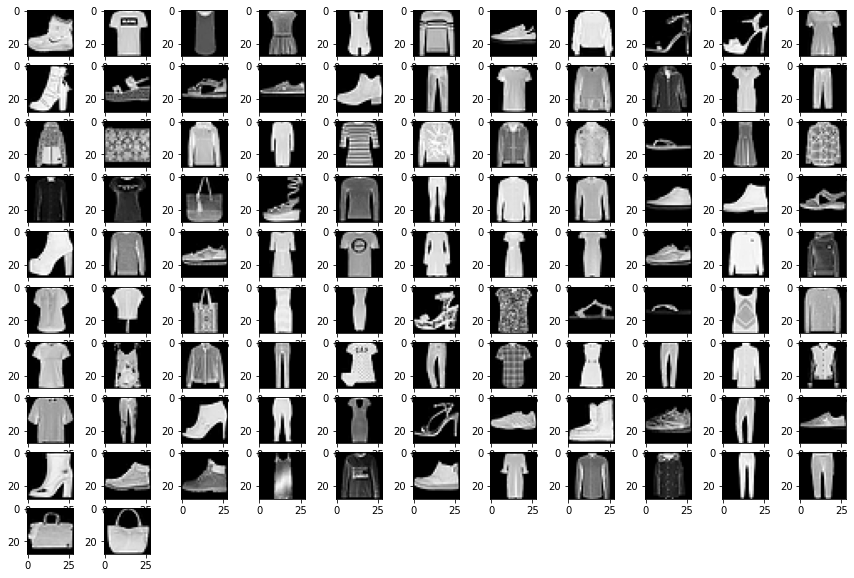

In [ ]:
n = 100
plt.figure(figsize = (15,10))
for i in range(n+1):
  plt.subplot(int(sqrt(n)),int(sqrt(n))+1,i+1)
  plt.imshow(dataset[i][0][0], cmap='gray')

## **Train**

In [ ]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50
batch_size =  32
lr=1e-4

train(score_model, n_epochs = n_epochs, lr = lr, dataloader = data_loader, output_file = 'fashion.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


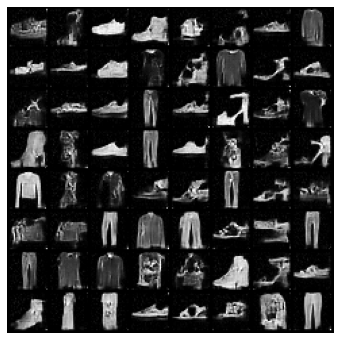

In [ ]:
## Load the pre-trained checkpoint from disk.
device = 'cuda' 
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
sampler = Euler_Maruyama_sampler 

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

# **Data loading**
In this part we will load several audio files and create an homegeneous dataset using those audio files (fixed lentgh, etc..)


## **Import and process data**
We will import 11 wav files from drive and slice each file into small same-length slices

In [ ]:
# Import PyDrive and associated libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1Aq1jhEFylrJ2QDQFU3keKhpMffdiGPX3'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('single_note.zip')

!unzip single_note.zip

Archive:  single_note.zip
   creating: single_note_c/
  inflating: single_note_c/sol-1.wav  
  inflating: __MACOSX/single_note_c/._sol-1.wav  
  inflating: single_note_c/ré#.wav  
  inflating: __MACOSX/single_note_c/._ré#.wav  
  inflating: single_note_c/fa.wav    
  inflating: __MACOSX/single_note_c/._fa.wav  
  inflating: single_note_c/ré3.wav  
  inflating: __MACOSX/single_note_c/._ré3.wav  
  inflating: single_note_c/ré#2.wav  
  inflating: __MACOSX/single_note_c/._ré#2.wav  
  inflating: single_note_c/ré#3.wav  
  inflating: __MACOSX/single_note_c/._ré#3.wav  
  inflating: single_note_c/ré2.wav  
  inflating: __MACOSX/single_note_c/._ré2.wav  
  inflating: single_note_c/do#3.wav  
  inflating: __MACOSX/single_note_c/._do#3.wav  
  inflating: single_note_c/do.wav    
  inflating: __MACOSX/single_note_c/._do.wav  
  inflating: single_note_c/do#2.wav  
  inflating: __MACOSX/single_note_c/._do#2.wav  
  inflating: single_note_c/ré.wav  
  inflating: __MACOSX/single_note_c/.

We want to change the start date and the end date of each file to have a more relevant dataset (delete white noise and silence at the begining and at the end)

In [ ]:
folder = 'single_note_c/'

In [ ]:
# Create the /data directory with all the slices
output_dir = 'data'
# slice_duration = get_square_time(4, 48000)
slice_duration = 0.5 # 256**2/44100

transform_directory(input_directory = 'single_note_c', output_directory = output_dir , slice_duration = slice_duration)
print(len(os.listdir(output_dir)),'files have been created in the folder','/'+output_dir)

6549 files have been created in the folder /data


In [ ]:
# Reduce the size of each file to 256**2/44100 = 1.49s (files have initial length of 1.5s with a small silence at the end)
input_directory = 'data'
output_directory = 'data_single_note'
transform_directory(input_directory, output_directory, slice_duration = 128**2/44100)

'6549 files have been created in the folder data_single_note'

## **Data processing and augmentation**
In this part, we use the ```librosa``` library to edit the files and to create additional data points using the existing data set by splitting the dataset and modifying channel and frequency parameters.

### **Stereo to mono**

In [ ]:
def stereo_to_mono(audiodata):
    newaudiodata = []

    for i in range(len(audiodata)):
        d = (audiodata[i][0])/2 + (audiodata[i][1])/2
        newaudiodata.append(d)

    return np.array(newaudiodata, dtype='int16')


def directory_to_mono(input_directory, output_directory):
  slice_array = []
  
  # Iterate recursively on all the wav files in the directory
  count = 0
  for subdir, dirs, files in os.walk(input_directory):
    for file in files:
      path_to_file = os.path.join(subdir, file)
      if path_to_file.endswith('.wav'):
        if count%1000 == 0: 
          print(100*count/(2183*3),'%')
        count += 1
        samplerate, audiodata = wavfile.read(path_to_file)
        newaudiodata = stereo_to_mono(audiodata)
        slice_array.append([output_directory+'/'+path_to_file.split('/')[-1],samplerate, np.int16(newaudiodata)])
  
  # Create the files in the output directory
  count = 0
  os.makedirs(output_directory)
  for file_slice in slice_array:
    wavfile.write(*file_slice)


  return str(len(slice_array)) + ' files have been created in the folder ' + output_directory

In [ ]:
directory_to_mono(input_directory = 'data_single_note', output_directory = 'data_mono')

0.0 %
15.269506794930523 %
30.539013589861046 %
45.80852038479157 %
61.07802717972209 %
76.34753397465262 %
91.61704076958314 %


'6549 files have been created in the folder data_mono'

In [ ]:
# Save zip file to reload later
# !zip -r /content/data_mono.zip /content/data_mono

### **Filtering**

In [ ]:
# Use librosa to visualize the fourrier transform of some data points
def plot_fft(path_to_file, title = None):
  waveform, samplerate = librosa.load(path_to_file, sr = 44100)
  fft = np.fft.fft(waveform)
  magnitude = np.abs(fft)
  frequency = np.linspace(0, samplerate, len(magnitude))
  plt.plot(frequency, magnitude)
  plt.xlabel('Frequency')
  plt.ylabel('Magnitude')
  if title is not None:
    plt.title(title)
  return

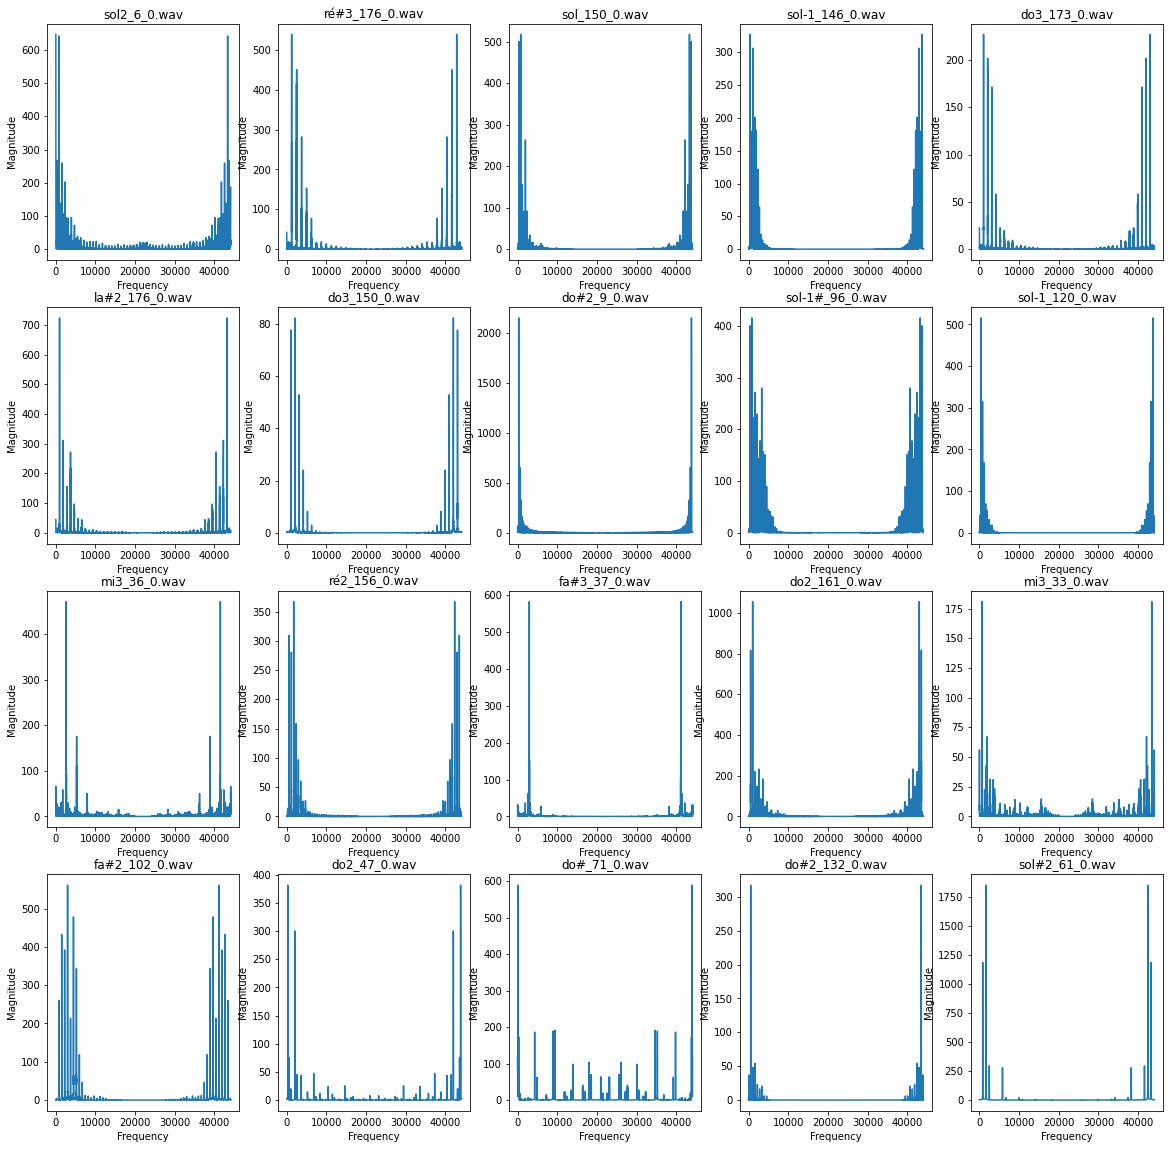

In [ ]:
# And plot the fft for a few files
n = 20
plt.figure(figsize = (20,20))
for i in range(n):
  path_to_file = random.choice(os.listdir('data_mono'))
  plt.subplot(int(sqrt(n)),int(sqrt(n))+1,i+1)
  plot_fft(path_to_file = 'data_mono/' + path_to_file, title = path_to_file)
plt.show()

We observe that the fft for our files is symetric. Given that the human ear cannot hear sounds above 16-18 kHz, we can edit our files by filtering all frequencies above this threshold using a low pass filter.

In [ ]:
# Low pass filter to cut frequencies above 20 kHz
from pydub import AudioSegment

def directory_lp_filter(input_directory, output_directory, freq = 10000):
  
  # Iterate recursively on all the wav files in the directory
  count = 0
  os.makedirs(output_directory)
  for subdir, dirs, files in os.walk(input_directory):
    for file in files:
      path_to_file = os.path.join(subdir, file)
      if path_to_file.endswith('.wav'):
        if count%1000 == 0: 
          print(100*count/(2183*3),'%')
        count += 1
        waveform, samplerate = librosa.load(path_to_file, sr = 44100)

        song = AudioSegment.from_wav(path_to_file)
        new = song.low_pass_filter(freq)
        new.export(output_directory+'/'+path_to_file.split('/')[-1])


  return count + ' files have been created in the folder ' + output_directory

In [ ]:
directory_lp_filter(input_directory = 'data_mono', output_directory = 'data_final', freq = 10000)

In [ ]:
# Save zip file to reload later
!zip -r /content/data_final.zip /content/data_final

Streaming output truncated to the last 5000 lines.
  adding: content/data_final/do2_76_0.wav (deflated 9%)
  adding: content/data_final/fa_7_0.wav (deflated 8%)
  adding: content/data_final/ré#_142_0.wav (deflated 9%)
  adding: content/data_final/fa_25_0.wav (deflated 13%)
  adding: content/data_final/mi2_119_0.wav (deflated 8%)
  adding: content/data_final/sol3_9_0.wav (deflated 9%)
  adding: content/data_final/mi2_139_0.wav (deflated 9%)
  adding: content/data_final/ré2_57_0.wav (deflated 8%)
  adding: content/data_final/sol-1#_166_0.wav (deflated 8%)
  adding: content/data_final/sol#_152_0.wav (deflated 8%)
  adding: content/data_final/do#3_160_0.wav (deflated 10%)
  adding: content/data_final/mi2_28_0.wav (deflated 16%)
  adding: content/data_final/ré#2_34_0.wav (deflated 6%)
  adding: content/data_final/mi_74_0.wav (deflated 9%)
  adding: content/data_final/fa_43_0.wav (deflated 13%)
  adding: content/data_final/fa#2_173_0.wav (deflated 8%)
  adding: content/data_final/si_81_0.

## **Create a dataloader**

In [ ]:
# Load data_final from Drive
# Import PyDrive and associated libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1q02H8a7jWWDpdVZ4I5Osw-D1dXEUXZR6' #data_mono
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data_final.zip')

!unzip data_final.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/data_mono/do2_76_0.wav  
  inflating: content/data_mono/fa_7_0.wav  
  inflating: content/data_mono/ré#_142_0.wav  
  inflating: content/data_mono/fa_25_0.wav  
  inflating: content/data_mono/mi2_119_0.wav  
  inflating: content/data_mono/sol3_9_0.wav  
  inflating: content/data_mono/mi2_139_0.wav  
  inflating: content/data_mono/ré2_57_0.wav  
  inflating: content/data_mono/sol-1#_166_0.wav  
  inflating: content/data_mono/sol#_152_0.wav  
  inflating: content/data_mono/do#3_160_0.wav  
  inflating: content/data_mono/mi2_28_0.wav  
  inflating: content/data_mono/ré#2_34_0.wav  
  inflating: content/data_mono/mi_74_0.wav  
  inflating: content/data_mono/fa_43_0.wav  
  inflating: content/data_mono/fa#2_173_0.wav  
  inflating: content/data_mono/si_81_0.wav  
  inflating: content/data_mono/la2_45_0.wav  
  inflating: content/data_mono/do_7_0.wav  
  inflating: content/data_mono/mi_9_0.wav  
  inflating: content/d

In [ ]:
batch_size =  32 #@param {'type':'integer'}
num_workers =  2#@param {'type':'integer'}
directory = 'content/data_mono'
audio_ds = AudioDataset(directory, normalize = 'squared_matrix')
audio_dl = DataLoader(audio_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

content/data_mono/do#2_27_0.wav
AudioMetaData(sample_rate=44100, num_frames=16384, num_channels=1, bits_per_sample=16, encoding=PCM_S)
Sample Rate: 44100
Shape: (1, 16384)
Dtype: torch.float32
 - Max:      0.162
 - Min:     -0.196
 - Mean:    -0.000
 - Std Dev:  0.043

tensor([[ 0.0003,  0.0002,  0.0002,  ..., -0.0190, -0.0148, -0.0110]])



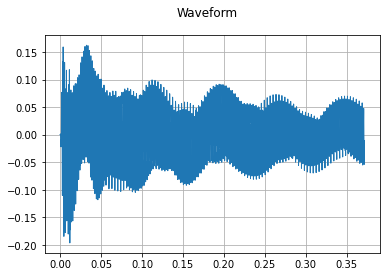

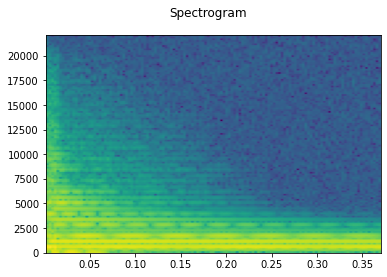

In [ ]:
# Visualize a file in the AudioDataset
idx = 1 #@param {'type': 'integer'}
file_name = audio_ds.get_file_name(idx)

metadata = torchaudio.info(file_name)
print(file_name)
print(metadata)

waveform, sample_rate = torchaudio.load(file_name)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

# **Score-based generative models**


## **4-Layers U-Net**
A first idea would be to adapt the U-Net model used in the paper's example

In [ ]:
### Define the Neural Network

# First class to create gaussian random weights lambda(t)
class GaussianFourierProjection(nn.Module):
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=128):
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 1, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 1, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 1, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 1, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 1, stride=2, bias=False, output_padding=1)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 1, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 1, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 1, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))   
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)

    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4) 

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)

    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)

    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
ScoreNet(marginal_prob_std=marginal_prob_std_fn).forward

<bound method ScoreNet.forward of ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (dense1): Dense(
    (dense): Linear(in_features=128, out_features=32, bias=True)
  )
  (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense2): Dense(
    (dense): Linear(in_features=128, out_features=64, bias=True)
  )
  (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense3): Dense(
    (dense): Linear(in_features=128, out_features=128, bias=True)
  )
  (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense4): Dense(
    (dense): Linear(in_features=128, out_features=256, bias=True)
  )
  (gnorm4): GroupNor

## **5-Layers  U-Net**

In [ ]:
class DeeperScoreNet(nn.Module):
  # Another version of the same U-net with an additional layer 
  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256, 512], embed_dim=128):
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 1, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 1, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 1, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 1, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    
    self.conv5 = nn.Conv2d(channels[3], channels[4], 1, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[4])
    self.gnorm5 = nn.GroupNorm(32, num_channels=channels[4])    



    # Decoding layers where the resolution increases
    self.tconv5 = nn.ConvTranspose2d(channels[4], channels[3], 1, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[3])
    self.tgnorm5 = nn.GroupNorm(32, num_channels=channels[3])

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 1, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 1, stride=2, bias=False, output_padding=1)    
    self.dense8 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 1, stride=2, bias=False, output_padding=1)    
    self.dense9 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 1, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))   
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)

    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4) 

    h5 = self.conv5(h4)
    h5 += self.dense5(embed)
    h5 = self.gnorm5(h5)
    h5 = self.act(h5) 

    # Decoding path

    h = self.tconv5(h5)
    ## Skip connection from the encoding path
    h += self.dense6(embed)
    h = self.tgnorm5(h)
    h = self.act(h)

    h = self.tconv4(h4)
    h += self.dense7(embed)
    h = self.tgnorm4(h)
    h = self.act(h)

    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense8(embed)
    h = self.tgnorm3(h)
    h = self.act(h)

    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense9(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
DeeperScoreNet(marginal_prob_std=marginal_prob_std_fn).forward

<bound method DeeperScoreNet.forward of DeeperScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (dense1): Dense(
    (dense): Linear(in_features=128, out_features=32, bias=True)
  )
  (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense2): Dense(
    (dense): Linear(in_features=128, out_features=64, bias=True)
  )
  (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense3): Dense(
    (dense): Linear(in_features=128, out_features=128, bias=True)
  )
  (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense4): Dense(
    (dense): Linear(in_features=128, out_features=256, bias=True)
  )
  (gnorm

## **6-Layers U-Net**

In [ ]:
class L6ScoreNet(nn.Module):
  # Another version of the same U-net with an additional layer 
  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256, 512, 1024], embed_dim=128):
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 1, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 1, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 1, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 1, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    
    self.conv5 = nn.Conv2d(channels[3], channels[4], 1, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[4])
    self.gnorm5 = nn.GroupNorm(32, num_channels=channels[4])   
    self.conv6 = nn.Conv2d(channels[4], channels[5], 1, stride=2, bias=False)
    self.denseY = Dense(embed_dim, channels[5])
    self.gnorm6 = nn.GroupNorm(32, num_channels=channels[5])   



    # Decoding layers where the resolution increases
    self.tconv6 = nn.ConvTranspose2d(channels[5], channels[4], 1, stride=2, bias=False, output_padding=1)
    self.denseX = Dense(embed_dim, channels[4])
    self.tgnorm6 = nn.GroupNorm(32, num_channels=channels[4])


    self.tconv5 = nn.ConvTranspose2d(channels[4], channels[3], 1, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[3])
    self.tgnorm5 = nn.GroupNorm(32, num_channels=channels[3])

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 1, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 1, stride=2, bias=False, output_padding=1)    
    self.dense8 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 1, stride=2, bias=False, output_padding=1)    
    self.dense9 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 1, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))   
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)

    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4) 

    h5 = self.conv5(h4)
    h5 += self.dense5(embed)
    h5 = self.gnorm5(h5)
    h5 = self.act(h5) 

    h6 = self.conv6(h5)
    h6 += self.denseY(embed)
    h6 = self.gnorm6(h6)
    h6 = self.act(h6) 

    # Decoding path

    h = self.tconv6(h6)
    ## Skip connection from the encoding path
    h += self.denseX(embed)
    h = self.tgnorm6(h)
    h = self.act(h)


    h = self.tconv5(h5)
    ## Skip connection from the encoding path
    h += self.dense6(embed)
    h = self.tgnorm5(h)
    h = self.act(h)

    h = self.tconv4(h4)
    h += self.dense7(embed)
    h = self.tgnorm4(h)
    h = self.act(h)

    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense8(embed)
    h = self.tgnorm3(h)
    h = self.act(h)

    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense9(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
L6ScoreNet(marginal_prob_std=marginal_prob_std_fn).forward

<bound method L6ScoreNet.forward of L6ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (dense1): Dense(
    (dense): Linear(in_features=128, out_features=32, bias=True)
  )
  (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense2): Dense(
    (dense): Linear(in_features=128, out_features=64, bias=True)
  )
  (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
  (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense3): Dense(
    (dense): Linear(in_features=128, out_features=128, bias=True)
  )
  (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (dense4): Dense(
    (dense): Linear(in_features=128, out_features=256, bias=True)
  )
  (gnorm4): Grou

# **Create a dataloader**

In [ ]:
# Load data_final from Drive
# Import PyDrive and associated libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# file_id = '1z2NO2mmu5Lpi_fGuf1_Rq5Dnih5Z2h4r' # data_final
file_id = '1q02H8a7jWWDpdVZ4I5Osw-D1dXEUXZR6' #data_mono
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data_final.zip')

!unzip data_final.zip

Archive:  data_final.zip
replace content/data_mono/ré_90_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
batch_size =  32 #@param {'type':'integer'}
num_workers =  2#@param {'type':'integer'}
directory = 'content/data_mono'
audio_ds = AudioDataset(directory, normalize = 'squared_matrix')
audio_dl = DataLoader(audio_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

content/data_mono/do#2_27_0.wav
AudioMetaData(sample_rate=44100, num_frames=16384, num_channels=1, bits_per_sample=16, encoding=PCM_S)
Sample Rate: 44100
Shape: (1, 16384)
Dtype: torch.float32
 - Max:      0.162
 - Min:     -0.196
 - Mean:    -0.000
 - Std Dev:  0.043

tensor([[ 0.0003,  0.0002,  0.0002,  ..., -0.0190, -0.0148, -0.0110]])



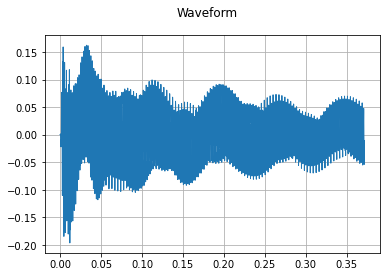

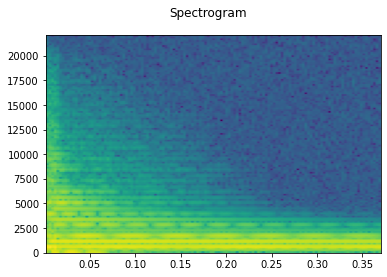

In [ ]:
# Visualize a file in the AudioDataset
idx = 1 #@param {'type': 'integer'}
file_name = audio_ds.get_file_name(idx)

metadata = torchaudio.info(file_name)
print(file_name)
print(metadata)

waveform, sample_rate = torchaudio.load(file_name)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

# **Train the initial model and generate samples**

### **Train**

In [ ]:
device = 'cuda' #@ param ['cuda','cpu'] {type:'string'}

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## learning raten

lr=1e-4 #@param {'type':'number'}

train(score_model, n_epochs = n_epochs, lr = lr, dataloader = audio_dl, output_file = None)

In [ ]:
# Uncomment to dowload the trained model

# file_id = '1g4hj30sYHCOUpr9S8k0lLFOrT796AfYM'
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('ckpt_init.pth')

### **Generate samples**

In [ ]:
## Load the pre-trained checkpoint from disk.
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_init.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size =  32#@param {'type':'integer'}


## Generate samples using the Euler_Maruyama_sampler sampler.
print('Generate',sample_batch_size,'samples, using Euler Maruyama sampler')
sampler = Euler_Maruyama_sampler
samples_em = generate_samples(score_model, sampler, sample_batch_size = sample_batch_size)

## Generate samples using the PC sampler.
print('Generate',sample_batch_size,'samples, using PC sampler')
sampler = pc_sampler 
samples_pc = generate_samples(score_model, sampler, sample_batch_size = sample_batch_size)

## Generate samples using the ODE sampler.
print('Generate',sample_batch_size,'samples, using ODE sampler')
sampler = ode_sampler
samples_ode = generate_samples(score_model, sampler, sample_batch_size = sample_batch_size)


Generate 32 samples, using Euler Maruyama sampler


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Generate 32 samples, using PC sampler


  0%|          | 0/500 [00:00<?, ?it/s]

Generate 32 samples, using ODE sampler
Number of function evaluations: 572


In [ ]:
# Save into a new folder
os.makedirs('samples')
os.makedirs('samples/em')
os.makedirs('samples/ode')
os.makedirs('samples/pc')
sample_rate = 48000
samples_array = []

# EM
for i in range(samples_em.shape[0]):
  path = 'samples/em/sample'+str(i)+'.wav'
  sample = samples_em[i]
  torchaudio.save(path, samples_em[i].cpu(), sample_rate)

# ODE
for i in range(samples_ode.shape[0]):
  path = 'samples/ode/sample'+str(i)+'.wav'
  sample = samples_ode[i]
  torchaudio.save(path, samples_ode[i].cpu(), sample_rate)

# PC
for i in range(samples_pc.shape[0]):
  path = 'samples/pc/sample'+str(i)+'.wav'
  sample = samples_pc[i]
  torchaudio.save(path, samples_pc[i].cpu(), sample_rate)

In [ ]:
# Display the samples
n = 5

for i in range(n):
  path = 'samples/em/sample'+str(i)+'.wav'
  waveform, sample_rate = torchaudio.load(path)
  print(path)
  play_audio(waveform, sample_rate)


  path = 'samples/ode/sample'+str(i)+'.wav'
  waveform, sample_rate = torchaudio.load(path)
  print(path)
  play_audio(waveform, sample_rate)


  path = 'samples/pc/sample'+str(i)+'.wav'
  waveform, sample_rate = torchaudio.load(path)
  print(path)
  play_audio(waveform, sample_rate)

samples/em/sample0.wav


samples/ode/sample0.wav


samples/pc/sample0.wav


samples/em/sample1.wav


samples/ode/sample1.wav


samples/pc/sample1.wav


samples/em/sample2.wav


samples/ode/sample2.wav


samples/pc/sample2.wav


samples/em/sample3.wav


samples/ode/sample3.wav


samples/pc/sample3.wav


samples/em/sample4.wav


samples/ode/sample4.wav


samples/pc/sample4.wav


### **Compute likelihood**

In [ ]:
batch_size =  32 
num_workers =  2

directory = 'content/data_mono'
audio_ds = AudioDataset(directory, normalize = 'squared_matrix')
audio_dl = DataLoader(audio_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

ckpt = torch.load('ckpt_init.pth', map_location=device)
score_model.load_state_dict(ckpt)

all_bpds = 0.
all_items = 0
try:
  tqdm_data = tqdm.notebook.tqdm(audio_dl)
  for x, _ in tqdm_data:
    x = x.to(device)
    # uniform dequantization
    x = (x * 255. + torch.rand_like(x)) / 256.    
    _, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                            diffusion_coeff_fn,
                            x.shape[0], device=device, eps=1e-5)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    tqdm_data.set_description("Average bits/dim: {:5f}".format(all_bpds / all_items))

except KeyboardInterrupt:
  # Remove the error message when interuptted by keyboard or GUI.
  pass
print(bpd)

  0%|          | 0/205 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


tensor([7.2329, 6.8687, 5.4502, 5.0864, 7.1100, 4.8752, 6.6072, 4.5061, 5.5864,
        7.4446, 5.2048, 5.1080, 5.7303, 6.8235, 6.9114, 6.0753, 8.3328, 4.6066,
        7.5288, 6.4117, 7.6388, 7.2352, 6.7255, 6.3405, 4.9186, 5.9605, 6.6484,
        6.6485, 5.5670, 7.7170, 8.1474, 5.8324], device='cuda:0',
       dtype=torch.float64)


# **Hyperparameters and model tuning**

In [ ]:
def grid_train(id, channels_tab, n_epochs_tab, layers_tab, lr_tab, dataloader = audio_dl):
  param_dict = {}
  count = 0
  for channels in channels_tab:
      for n_epochs in n_epochs_tab:
          for layers in layers_tab:
              for lr in lr_tab:
                  output_file = 'models/unet_'+id+str(count)+'.pth'
                  
                  if layers == 4:
                    score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
                    score_model = score_model.to(device)

                    train(score_model, n_epochs = n_epochs, lr = lr, dataloader = dataloader, output_file = output_file)
                    count += 1
                    param_dict[output_file] = {'channels':channels, 'n_epochs':n_epochs, 'layers':layers, 'lr':lr}

                  elif layers == 5:
                    score_model = torch.nn.DataParallel(DeeperScoreNet(marginal_prob_std=marginal_prob_std_fn))
                    score_model = score_model.to(device)
                    
                    train(score_model, n_epochs = n_epochs, lr = lr, dataloader = dataloader, output_file = output_file)
                    count += 1
                    param_dict[output_file] = {'channels':channels, 'n_epochs':n_epochs, 'layers':layers, 'lr':lr}

                  elif layers == 6:
                    score_model = torch.nn.DataParallel(L6ScoreNet(marginal_prob_std=marginal_prob_std_fn))
                    score_model = score_model.to(device)
                    
                    train(score_model, n_epochs = n_epochs, lr = lr, dataloader = dataloader, output_file = output_file)
                    count += 1
                    param_dict[output_file] = {'channels':channels, 'n_epochs':n_epochs, 'layers':layers, 'lr':lr}
                  print('Model saved:',output_file)

  return param_dict

## **Train the models**

In [ ]:
os.makedirs('models')

### 4-Layers U-Net

In [ ]:
# os.makedirs('models')
train_args_4 = [
              [[32,64,128,256]],
              [10,20,50],
              [4],
              [1e-3,1e-4,1e-5]
]
param_dict_4 = grid_train(channels_tab = train_args_4[0], n_epochs_tab = train_args_4[1], id = 'iter_on_epochs_lr', layers_tab = train_args_4[2], lr_tab = train_args_4[3], dataloader = audio_dl)
print(param_dict_4)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Model saved: models/unet_iter_on_epochs_lr_0.pth


  0%|          | 0/20 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_epochs_lr_1.pth


  0%|          | 0/20 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_epochs_lr_2.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_epochs_lr_3.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_epochs_lr_4.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_epochs_lr_5.pth
{'models/unet_iter_on_epochs_lr_0.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 20, 'layers': 4, 'lr': 0.001}, 'models/unet_iter_on_epochs_lr_1.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 20, 'layers': 4, 'lr': 0.0001}, 'models/unet_iter_on_epochs_lr_2.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 20, 'layers': 4, 'lr': 1e-05}, 'models/unet_iter_on_epochs_lr_3.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 0.001}, 'models/unet_iter_on_epochs_lr_4.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001}, 'models/unet_iter_on_epochs_lr_5.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05}}


In [ ]:
train_args_4 = [
              [[128,128,128,256],[128,256,256,512],[128,256,512,1024]],
              [50],
              [4],
              [1e-4]
]
param_dict_4_1 = grid_train(channels_tab = train_args_4[0], n_epochs_tab = train_args_4[1], id = 'iter_on_channels', layers_tab = train_args_4[2], lr_tab = train_args_4[3], dataloader = audio_dl)
print(param_dict_4)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Model saved: models/unet_iter_on_channels_0.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_channels_1.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_channels_2.pth
{'models/unet_iter_on_epochs_lr_0.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 20, 'layers': 4, 'lr': 0.001}, 'models/unet_iter_on_epochs_lr_1.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 20, 'layers': 4, 'lr': 0.0001}, 'models/unet_iter_on_epochs_lr_2.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 20, 'layers': 4, 'lr': 1e-05}, 'models/unet_iter_on_epochs_lr_3.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 0.001}, 'models/unet_iter_on_epochs_lr_4.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001}, 'models/unet_iter_on_epochs_lr_5.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05}}


In [ ]:
print(param_dict_4_1)

{'models/unet_iter_on_channels_0.pth': {'channels': [128, 128, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001}, 'models/unet_iter_on_channels_1.pth': {'channels': [128, 256, 256, 512], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001}, 'models/unet_iter_on_channels_2.pth': {'channels': [128, 256, 512, 1024], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001}}


In [ ]:
train_args_4 = [
              [[128,128,128,256],[128,256,256,512],[128,256,512,1024]],
              [50],
              [4],
              [1e-5]
]
param_dict_4_2 = grid_train(channels_tab = train_args_4[0], n_epochs_tab = train_args_4[1], id = 'iter_on_channels', layers_tab = train_args_4[2], lr_tab = train_args_4[3], dataloader = audio_dl)
print(param_dict_4_2)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Model saved: models/unet_iter_on_channels_0.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_channels_1.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_on_channels_2.pth
{'models/unet_iter_on_channels_0.pth': {'channels': [128, 128, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05}, 'models/unet_iter_on_channels_1.pth': {'channels': [128, 256, 256, 512], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05}, 'models/unet_iter_on_channels_2.pth': {'channels': [128, 256, 512, 1024], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05}}


### 5-Layers U-Net

In [ ]:
# First model: unet_iter_5layers_10.pth [32,64,128,256,512]

train_args_5 = [
              'iter_5_layers_2_',
              [[128,128,128,128,128],[128,256,256,512,1024]],
              [50],
              [5],
              [1e-4]
]


param_dict_5 = grid_train(id = train_args_5[0], channels_tab = train_args_5[1], n_epochs_tab = train_args_5[2], layers_tab = train_args_5[3], lr_tab = train_args_5[4])
print(param_dict_5)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Model saved: models/unet_iter_5_layers_2_0.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_5_layers_2_1.pth
{'models/unet_iter_5_layers_2_0.pth': {'channels': [128, 128, 128, 128, 128], 'n_epochs': 50, 'layers': 5, 'lr': 0.0001}, 'models/unet_iter_5_layers_2_1.pth': {'channels': [128, 256, 256, 512, 1024], 'n_epochs': 50, 'layers': 5, 'lr': 0.0001}}


In [ ]:
train_args_5 = [
              'iter_5_layers_3_',
              [[128,256,256,256,512],[128,256,512,1024,2048]],
              [50],
              [5],
              [1e-4]
]


param_dict_5 = grid_train(id = train_args_5[0], channels_tab = train_args_5[1], n_epochs_tab = train_args_5[2], layers_tab = train_args_5[3], lr_tab = train_args_5[4])
print(param_dict_5)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Model saved: models/unet_iter_5_layers_3_0.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_5_layers_3_1.pth
{'models/unet_iter_5_layers_3_0.pth': {'channels': [128, 256, 256, 256, 512], 'n_epochs': 50, 'layers': 5, 'lr': 0.0001}, 'models/unet_iter_5_layers_3_1.pth': {'channels': [128, 256, 512, 1024, 2048], 'n_epochs': 50, 'layers': 5, 'lr': 0.0001}}


### 6-Layers U-Net

In [ ]:
train_args_6 = [
              'iter_6_layers_',
              [[64,128,256,512,1024,2048],[128,256,512,512,1024,2048],[128,256,512,1024,2048,4096],[128,256,256,512,512,512]],
              [50],
              [6],
              [1e-4]
]


param_dict_6 = grid_train(id = train_args_6[0], channels_tab = train_args_6[1], n_epochs_tab = train_args_6[2], layers_tab = train_args_6[3], lr_tab = train_args_6[4])
print(param_dict_6)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Model saved: models/unet_iter_6_layers_0.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_6_layers_1.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_6_layers_2.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_6_layers_3.pth
{'models/unet_iter_6_layers_0.pth': {'channels': [64, 128, 256, 512, 1024, 2048], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}, 'models/unet_iter_6_layers_1.pth': {'channels': [128, 256, 512, 512, 1024, 2048], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}, 'models/unet_iter_6_layers_2.pth': {'channels': [128, 256, 512, 1024, 2048, 4096], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}, 'models/unet_iter_6_layers_3.pth': {'channels': [128, 256, 256, 512, 512, 512], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}}


In [ ]:
train_args_6 = [
              'iter_6_layers_',
              [[128,256,512,1024,2048,4096],[128,256,256,512,512,512]],
              [50],
              [6],
              [1e-4]
]
os.makedirs('models')

param_dict_6 = grid_train(id = train_args_6[0], channels_tab = train_args_6[1], n_epochs_tab = train_args_6[2], layers_tab = train_args_6[3], lr_tab = train_args_6[4])
print(param_dict_6)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Model saved: models/unet_iter_6_layers_0.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Model saved: models/unet_iter_6_layers_1.pth
{'models/unet_iter_6_layers_0.pth': {'channels': [128, 256, 512, 1024, 2048, 4096], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}, 'models/unet_iter_6_layers_1.pth': {'channels': [128, 256, 256, 512, 512, 512], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}}


## **Load pretrained models**

In [ ]:
results = {
    'models/unet_iter_6_layers_0.pth': {'channels': [64, 128, 256, 512, 1024, 2048], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}, 
    'models/unet_iter_6_layers_1.pth': {'channels': [128, 256, 512, 512, 1024, 2048], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}, 
    'models/unet_iter_6_layers_2.pth': {'channels': [128, 256, 512, 1024, 2048, 4096], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001}, 
    'models/unet_iter_6_layers_3.pth': {'channels': [128, 256, 256, 512, 512, 512], 'n_epochs': 50, 'layers': 6, 'lr': 0.0001},
    'models/unet_iter_5_layers_2_0.pth': {'channels': [128, 128, 128, 128, 128], 'n_epochs': 50, 'layers': 5, 'lr': 0.0001}, 
    'models/unet_iter_5_layers_2_1.pth': {'channels': [128, 256, 256, 512, 1024], 'n_epochs': 50, 'layers': 5, 'lr': 0.0001},
    'models/unet_iter_5_layers_3_0.pth': {'channels': [128, 256, 256, 256, 512], 'n_epochs': 50, 'layers': 5, 'lr': 0.0001}, 
    'models/unet_iter_5_layers_3_1.pth': {'channels': [128, 256, 512, 1024, 2048], 'n_epochs': 50, 'layers': 5, 'lr': 0.0001},
    'models/unet_iter_on_epochs_lr_4.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001}, 
    'models/unet_iter_on_epochs_lr_5.pth': {'channels': [32, 64, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05},
    'models/unet_iter_on_channels_0.pth': {'channels': [128, 128, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001}, 
    'models/unet_iter_on_channels_1.pth': {'channels': [128, 256, 256, 512], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001}, 
    'models/unet_iter_on_channels_2.pth': {'channels': [128, 256, 512, 1024], 'n_epochs': 50, 'layers': 4, 'lr': 0.0001},
    'models/unet_iter_on_channels_1_0.pth': {'channels': [128, 128, 128, 256], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05}, 
    'models/unet_iter_on_channels_1_1.pth': {'channels': [128, 256, 256, 512], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05}, 
    'models/unet_iter_on_channels_1_2.pth': {'channels': [128, 256, 512, 1024], 'n_epochs': 50, 'layers': 4, 'lr': 1e-05},
    }

In [ ]:
# # Uncomment to load the pretrained models from Drive
# # Import PyDrive and associated libraries.
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# file_id = '1SgE9KXQLYyoEiLIelh1M097yBiq83LL2'
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('models.zip')

# !unzip models.zip

Archive:  models.zip
  inflating: models/unet_iter_6_layers_1.pth  
  inflating: models/unet_iter_6_layers_3.pth  
  inflating: models/unet_iter_on_channels_0.pth  
  inflating: models/unet_iter_on_epochs_lr_2-1.pth  
  inflating: models/unet_iter_on_channels_1_1.pth  
  inflating: models/unet_iter_on_epochs_lr_5.pth  
  inflating: models/unet_iter_on_epochs_lr_0-1.pth  
  inflating: models/unet_iter_on_epochs_lr_3-1.pth  
  inflating: models/unet_iter_on_channels_1.pth  
  inflating: models/unet_iter_on_channels_2.pth  
  inflating: models/unet_iter_on_epochs_lr_1-1.pth  
  inflating: models/unet_iter_on_channels_1_0.pth  
  inflating: models/unet_iter_on_epochs_lr_4.pth  
  inflating: models/unet_iter_on_channels_1_2.pth  
  inflating: models/ckpt_init.pth    
  inflating: models/unet_iter_6_layers_0.pth  
  inflating: models/unet_iter_5_layers_2_1.pth  
  inflating: models/unet_iter_5_layers_3_0.pth  
  inflating: models/unet_iter_5_layers_3_1.pth  
  inflating: models/unet_iter_5_l

## **Generate new samples using each model**
To select the most efficient models among the list, we will generate samples using each model and try to determine what model produces samples that are not simple white noise.

In [ ]:
# Load the pretrained models and use the 3 samplers to generate new data points
for elem in results:
  print(elem)

  if results[elem]['layers'] == 4:
    score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn)).to(device)
  if results[elem]['layers'] == 5:
    score_model = torch.nn.DataParallel(DeeperScoreNet(marginal_prob_std=marginal_prob_std_fn)).to(device)
  if results[elem]['layers'] == 6:
    score_model = torch.nn.DataParallel(L6ScoreNet(marginal_prob_std=marginal_prob_std_fn)).to(device)

  score_model = score_model.to(device)
  ckpt = torch.load(elem, map_location=device)
  score_model.load_state_dict(ckpt)


  sampler = Euler_Maruyama_sampler
  samples_em = generate_samples(score_model, sampler, sample_batch_size = sample_batch_size)
  results[elem]['em_samples'] = samples_em

  sampler = pc_sampler 
  samples_pc = generate_samples(score_model, sampler, sample_batch_size = sample_batch_size)
  results[elem]['pc_samples'] = samples_pc

  sampler = ode_sampler
  samples_ode = generate_samples(score_model, sampler, sample_batch_size = sample_batch_size)
  results[elem]['ode_samples'] = samples_ode


models/unet_iter_6_layers_0.pth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 662
models/unet_iter_6_layers_1.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 668
models/unet_iter_6_layers_2.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 746
models/unet_iter_6_layers_3.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 566
models/unet_iter_5_layers_2_0.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 728
models/unet_iter_5_layers_2_1.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 1262
models/unet_iter_5_layers_3_0.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 860
models/unet_iter_5_layers_3_1.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 758
models/unet_iter_on_epochs_lr_4.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 1046
models/unet_iter_on_epochs_lr_5.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 746
models/unet_iter_on_channels_0.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 608
models/unet_iter_on_channels_1.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 638
models/unet_iter_on_channels_2.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 554
models/unet_iter_on_channels_1_0.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 1304
models/unet_iter_on_channels_1_1.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 680
models/unet_iter_on_channels_1_2.pth


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of function evaluations: 1010


In [ ]:
# Store the samples into a specific folder (to load later)
# os.makedirs('samples')
for elem in results:
  if not os.path.isdir('samples/'+elem): 
    os.makedirs('samples/'+elem)
  if not os.path.isdir('samples/'+elem+'/em'):   
    os.makedirs('samples/'+elem+'/em')
  if not os.path.isdir('samples/'+elem+'/ode'):   
    os.makedirs('samples/'+elem+'/ode')
  if not os.path.isdir('samples/'+elem+'/pc'):    
    os.makedirs('samples/'+elem+'/pc')
  sample_rate = 44100
  

  samples_em = results[elem]['em_samples']
  samples_ode = results[elem]['ode_samples']
  samples_pc = results[elem]['pc_samples']

  print(elem)
  # EM
  for i in range(samples_em.shape[0]):
    path = 'samples/'+elem+'/em/sample'+str(i)+'.wav'
    sample = samples_em[i]
    torchaudio.save(path, samples_em[i].cpu().type(torch.float32), sample_rate)

  # ODE
  for i in range(samples_ode.shape[0]):
    path = 'samples/'+elem+'/ode/sample'+str(i)+'.wav'
    sample = samples_ode[i]
    torchaudio.save(path, samples_ode[i].cpu().type(torch.float32), sample_rate)

  # PC
  for i in range(samples_pc.shape[0]):
    path = 'samples/'+elem+'/pc/sample'+str(i)+'.wav'
    sample = samples_pc[i]
    torchaudio.save(path, samples_pc[i].cpu().type(torch.float32), sample_rate)

models/unet_iter_6_layers_0.pth
models/unet_iter_6_layers_1.pth
models/unet_iter_6_layers_2.pth
models/unet_iter_6_layers_3.pth
models/unet_iter_5_layers_2_0.pth
models/unet_iter_5_layers_2_1.pth
models/unet_iter_5_layers_3_0.pth
models/unet_iter_5_layers_3_1.pth
models/unet_iter_on_epochs_lr_4.pth
models/unet_iter_on_epochs_lr_5.pth
models/unet_iter_on_channels_0.pth
models/unet_iter_on_channels_1.pth
models/unet_iter_on_channels_2.pth
models/unet_iter_on_channels_1_0.pth
models/unet_iter_on_channels_1_1.pth
models/unet_iter_on_channels_1_2.pth


In [ ]:
# Save zip file to reload later
# !zip -r /content/samples.zip /content/samples

  adding: content/samples/ (stored 0%)
  adding: content/samples/models/ (stored 0%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ (stored 0%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/ (stored 0%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/sample28.wav (deflated 45%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/sample2.wav (deflated 45%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/sample26.wav (deflated 45%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/sample29.wav (deflated 45%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/sample6.wav (deflated 45%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/sample21.wav (deflated 45%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/sample9.wav (deflated 47%)
  adding: content/samples/models/unet_iter_on_channels_2.pth/ode/sample30.wav (deflated 45%)
  adding: content/samp

## **Listen to the samples**

In [ ]:
# # Uncomment to load the samples

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# file_id = '1anygHFC601KyxTO2p0cVXUFIaA0w7r6t'
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('samples.zip')

# !unzip samples.zip

In [ ]:
def display_samples(n_samples = 1, results = results, wave = False, specgram = False, stats = False):
  for elem in results:
    print(n_samples,'samples, with a',results[elem]['layers'],'U-Net model (channels:',results[elem]['channels'],', learning rate:',results[elem]['lr'], 'and',results[elem]['n_epochs'],'epochs)')
    print('')
    print('Euler Maruyama sampler')
    for i in range(n_samples):
      path = 'samples/'+elem+'/em/sample'+str(i)+'.wav'
      waveform, sample_rate = torchaudio.load(path)
      print(path)
      play_audio(waveform, sample_rate)
      if stats:
        print_stats(waveform, sample_rate=sample_rate)
      if wave:
        plot_waveform(waveform, sample_rate)
      if specgram:
        plot_specgram(waveform, sample_rate)
    print('')    
    print('Predictor Corrector sampler')
    for i in range(n_samples):
      path = 'samples/'+elem+'/pc/sample'+str(i)+'.wav'
      waveform, sample_rate = torchaudio.load(path)
      print(path)
      play_audio(waveform, sample_rate)
      if stats:
        print_stats(waveform, sample_rate=sample_rate)
      if wave:
        plot_waveform(waveform, sample_rate)
      if specgram:
        plot_specgram(waveform, sample_rate)
    print('')
    print('ODE sampler')
    for i in range(n_samples):
      path = 'samples/'+elem+'/ode/sample'+str(i)+'.wav'
      waveform, sample_rate = torchaudio.load(path)
      print(path)
      play_audio(waveform, sample_rate)
      if stats:
        print_stats(waveform, sample_rate=sample_rate)
      if wave:
        plot_waveform(waveform, sample_rate)
      if specgram:
        plot_specgram(waveform, sample_rate)
    print('')
    print('')
    print('')
  return


In [ ]:
display_samples(n_samples = 1, results = results, wave = True, specgram = True, stats = True)